In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
csv = 'clean_stackoverflow_posts.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [ ]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596019 entries, 0 to 1596018
Data columns (total 2 columns):
text      1596019 non-null object
target    1596019 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
x = my_df.text
y = my_df.target

In [ ]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [ ]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [ ]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [ ]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596019/1596019 [00:01<00:00, 974931.80it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596019/1596019 [00:01<00:00, 1118170.79it/s]


CPU times: user 22min 1s, sys: 1min 3s, total: 23min 5s
Wall time: 9min 37s


In [ ]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596019/1596019 [00:02<00:00, 533098.47it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596019/1596019 [00:01<00:00, 1137897.00it/s]


CPU times: user 41min 35s, sys: 31.7 s, total: 42min 7s
Wall time: 12min 35s


In [ ]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

# Prepration for Convolutional Neural Network

In the last post, I have aggregated the word vectors of each word in a tweet, either summation or calculating mean to get one vector representation of each tweet. However, in order to feed to a CNN, we have to not only feed each word vector to the model, but also in a sequence which matches the original tweet.

Let's first load the Word2Vec models to extract word vectors from. I have saved the Word2Vec models I trained earlier, and can easily be loaded with "KeyedVectors" function in Gensim. I have two different Word2Vec models, one with CBOW (Continuous Bag Of Words) model, and the other with a skip-gram model. I won't go into detail of how CBOW and skip-gram differs.

In [ ]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [ ]:
len(model_ug_cbow.wv.vocab.keys())

106257

In [ ]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 106257 word vectors.


Now we have our reference to word vectors ready, but we still haven't prepared data to be in the format I have explained at the start of the post. Keras' 'Tokenizer' will split each word in a sentence,  then we can call 'texts_to_sequences' method to get the sequential representation of each sentence. We also need to pass 'num_words' which is a number of vocabularies you want to use, and this will be applied when you call 'texts_to_sequences' method. This might be a bit counter-intuitive since if you check the length of all the word index, it will not be the number of words you defined, but the actual screening process happens when you call 'texts_to_sequences' method.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [ ]:
len(tokenizer.word_index)

261650

Below are the first five entries of the original train data.

In [ ]:
for x in x_train[:5]:
    print x

hate you
got physics exam jealous
holy shit new vending machine blue lcd bit but no fun carousel delivery system
ha no went to real gym swear look what found of our fave things chocolate nathan
loved my doggie kisses made my day can not tell little bear tho


And the same data prepared as sequential dats is as below.

In [ ]:
sequences[:5]

[[137, 6],
 [45, 2569, 410, 555],
 [1311, 353, 69, 9569, 1496, 855, 9411, 235, 17, 35, 104, 18470, 2871, 1443],
 [384,
  35,
  203,
  1,
  372,
  629,
  1491,
  202,
  46,
  302,
  11,
  177,
  1417,
  223,
  673,
  4994],
 [502, 3, 4487, 2134, 195, 3, 29, 26, 7, 253, 157, 1758, 329]]

Each word is represented as a number, and we can see that the number of words in each sentence is matching the length of numbers in the "sequences". We can later make connections of which word each number represents. But we still didn't pad our data, so each sentence has varying length. Let's deal with this.

In [ ]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [ ]:
max(length)

40

The maximum number of words in a sentence within the training data is 40. Let's decide the maximum length to be a bit longer than this, let's say 45.

In [ ]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

('Shape of data tensor:', (1564098, 45))


In [ ]:
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   137,     6],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    45,  2569,   410,   555],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  1311,   353,    69,  9569,  1496,
    

As you can see from the padded sequences, all the data now transformed to have the same length of 45, and by default, Keras zero-pads at the beginning, if a sentence length is shorter than the maximum length. 

In [ ]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

There's still one more thing left to do before we can feed the sequential text data to a model. When we transformed a sentence into a sequence, each word is represented by an integer number. Actually, these numbers are where each word is stored in the tokenizer's word index. Keeping this in mind, let's build a matrix of these word vectors, but this time we will use the word index number so that our model can refer to the corresponding vector when fed with integer sequence.

In [ ]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of the training set, the first entry was "hate you", and the sequential representation of this was [137, 6]. Let's see if 6th embedding matrix is as same as vectors for the word 'you'.

In [ ]:
np.array_equal(embedding_matrix[6] ,embeddings_index.get('you'))

True

Now we are ready with the data preparation. Before we jump into CNN, I would like to test one more thing (sorry for the delay). When we feed this sequential vector representation of data, we will use Embedding layer in Keras. With Embedding layer, I can either pass pre-defined embedding, which I prepared as 'embedding_matrix' above, or Embedding layer itself can learn word embeddings as the whole model trains. And another possibility is we can still feed the pre-defined embedding but make it trainable so that it will update the values of vectors as the model trains.

In [ ]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 1394s - loss: 0.4614 - acc: 0.7799 - val_loss: 0.4479 - val_acc: 0.7909
Epoch 2/5
 - 1416s - loss: 0.4262 - acc: 0.8014 - val_loss: 0.4405 - val_acc: 0.7955
Epoch 3/5
 - 1342s - loss: 0.3997 - acc: 0.8167 - val_loss: 0.4512 - val_acc: 0.7932
Epoch 4/5
 - 1315s - loss: 0.3730 - acc: 0.8313 - val_loss: 0.4679 - val_acc: 0.7841
Epoch 5/5
 - 1297s - loss: 0.3475 - acc: 0.8450 - val_loss: 0.4943 - val_acc: 0.7844


In [ ]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=45)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 10985s - loss: 0.4219 - acc: 0.8054 - val_loss: 0.4029 - val_acc: 0.8210
Epoch 2/5
 - 10984s - loss: 0.3718 - acc: 0.8346 - val_loss: 0.4048 - val_acc: 0.8195
Epoch 3/5
 - 10975s - loss: 0.3236 - acc: 0.8595 - val_loss: 0.4293 - val_acc: 0.8161
Epoch 4/5
 - 11475s - loss: 0.2722 - acc: 0.8847 - val_loss: 0.4762 - val_acc: 0.8019
Epoch 5/5
 - 12110s - loss: 0.2277 - acc: 0.9052 - val_loss: 0.5349 - val_acc: 0.7951


In [ ]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11945s - loss: 0.4226 - acc: 0.8051 - val_loss: 0.4068 - val_acc: 0.8163
Epoch 2/5
 - 11473s - loss: 0.3783 - acc: 0.8305 - val_loss: 0.4086 - val_acc: 0.8186
Epoch 3/5
 - 10964s - loss: 0.3421 - acc: 0.8492 - val_loss: 0.4171 - val_acc: 0.8222
Epoch 4/5
 - 10968s - loss: 0.2992 - acc: 0.8708 - val_loss: 0.4530 - val_acc: 0.8137
Epoch 5/5
 - 10956s - loss: 0.2575 - acc: 0.8907 - val_loss: 0.4974 - val_acc: 0.8071


# Convolutional Neural Network

Now let's try to add more filters to our 1D Convolutional layer. If we apply 100 2X200 filters with stride size of 1 to 45X200 matrix, can you guess the output dimension?

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [ ]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 44, 100)           40100     
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now if we add Global Max Pooling layer, then the pooling layer will extract the maximum value from each filter, and the output dimension will be a just 1-dimensional vector with length as same as the number of filters we applied. This can be directly passed on to a dense layer without flattening.

In [ ]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 44, 100)           40100     
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 100)               0         
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now, let's define a simple CNN going through bigrams on a tweet. The output from global max pooling layer will be fed to a fully connected layer, then finally the output layer. Again I will try three different inputs, static word vectors extracted from Word2Vec, word embedding being learned from scratch with embedding layer, Word2Vec word vectors being updated through training.

In [ ]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 873s - loss: 0.4178 - acc: 0.8069 - val_loss: 0.4063 - val_acc: 0.8180
Epoch 2/5
 - 876s - loss: 0.3976 - acc: 0.8187 - val_loss: 0.4017 - val_acc: 0.8196
Epoch 3/5
 - 981s - loss: 0.3911 - acc: 0.8228 - val_loss: 0.3943 - val_acc: 0.8221
Epoch 4/5
 - 1013s - loss: 0.3873 - acc: 0.8248 - val_loss: 0.3932 - val_acc: 0.8220
Epoch 5/5
 - 1012s - loss: 0.3850 - acc: 0.8261 - val_loss: 0.3953 - val_acc: 0.8209


In [ ]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=45)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11835s - loss: 0.4098 - acc: 0.8121 - val_loss: 0.3910 - val_acc: 0.8244
Epoch 2/5
 - 11324s - loss: 0.3626 - acc: 0.8391 - val_loss: 0.3883 - val_acc: 0.8258
Epoch 3/5
 - 11300s - loss: 0.3315 - acc: 0.8566 - val_loss: 0.3955 - val_acc: 0.8271
Epoch 4/5
 - 11425s - loss: 0.3031 - acc: 0.8714 - val_loss: 0.4056 - val_acc: 0.8245
Epoch 5/5
 - 11222s - loss: 0.2770 - acc: 0.8846 - val_loss: 0.4341 - val_acc: 0.8162


In [ ]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11111s - loss: 0.4024 - acc: 0.8164 - val_loss: 0.3864 - val_acc: 0.8274
Epoch 2/5
 - 12249s - loss: 0.3655 - acc: 0.8372 - val_loss: 0.3805 - val_acc: 0.8299
Epoch 3/5
 - 12974s - loss: 0.3405 - acc: 0.8513 - val_loss: 0.3803 - val_acc: 0.8325
Epoch 4/5
 - 11721s - loss: 0.3164 - acc: 0.8644 - val_loss: 0.3897 - val_acc: 0.8293
Epoch 5/5
 - 12050s - loss: 0.2931 - acc: 0.8760 - val_loss: 0.4134 - val_acc: 0.8228


In [ ]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 45, 200)      20000000    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 44, 100)      40100       embedding_59[0][0]               
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 43, 100)      60100       embedding_59[0][0]               
__________________________________________________________________________________________________
conv1d_68 

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
1564098/1564098 [==============================] - 15337s 10ms/step - loss: 0.4028 - acc: 0.8183 - val_loss: 0.3812 - val_acc: 0.8315
Epoch 2/5
1564098/1564098 [==============================] - 15819s 10ms/step - loss: 0.3655 - acc: 0.8399 - val_loss: 0.3751 - val_acc: 0.8333
Epoch 3/5
1564098/1564098 [==============================] - 17413s 11ms/step - loss: 0.3381 - acc: 0.8541 - val_loss: 0.3856 - val_acc: 0.8294
Epoch 4/5
1564098/1564098 [==============================] - 16826s 11ms/step - loss: 0.3094 - acc: 0.8685 - val_loss: 0.3916 - val_acc: 0.8305
Epoch 5/5
1564098/1564098 [==============================] - 16517s 11ms/step - loss: 0.2797 - acc: 0.8829 - val_loss: 0.4120 - val_acc: 0.8256


In [ ]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.8333.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

15960/15960 [==============================] - 10s 640us/step


[0.3751017113078507, 0.8332706766917293]

The best validation accuracy is 83.33%, slightly better than the simple CNN model with bigram filters, which yielded 83.25% validation accuracy. 

## Final Model Evaluation with Test Set

So far I have tested the model on the validation set to decide the feature extraction tuning and model comparison. Now I will finally check the final result with the test set. I will compare two different models: 1. Tf-Idf + logistic regression, 2. Word2Vec + CNN. As another measure for comparison, I will also plot ROC curve of both models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [ ]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [ ]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.8329678591566945

In [ ]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [ ]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

15961/15961 [==============================] - 13s 844us/step


[0.3629236272231923, 0.8386066035813283]

In [ ]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

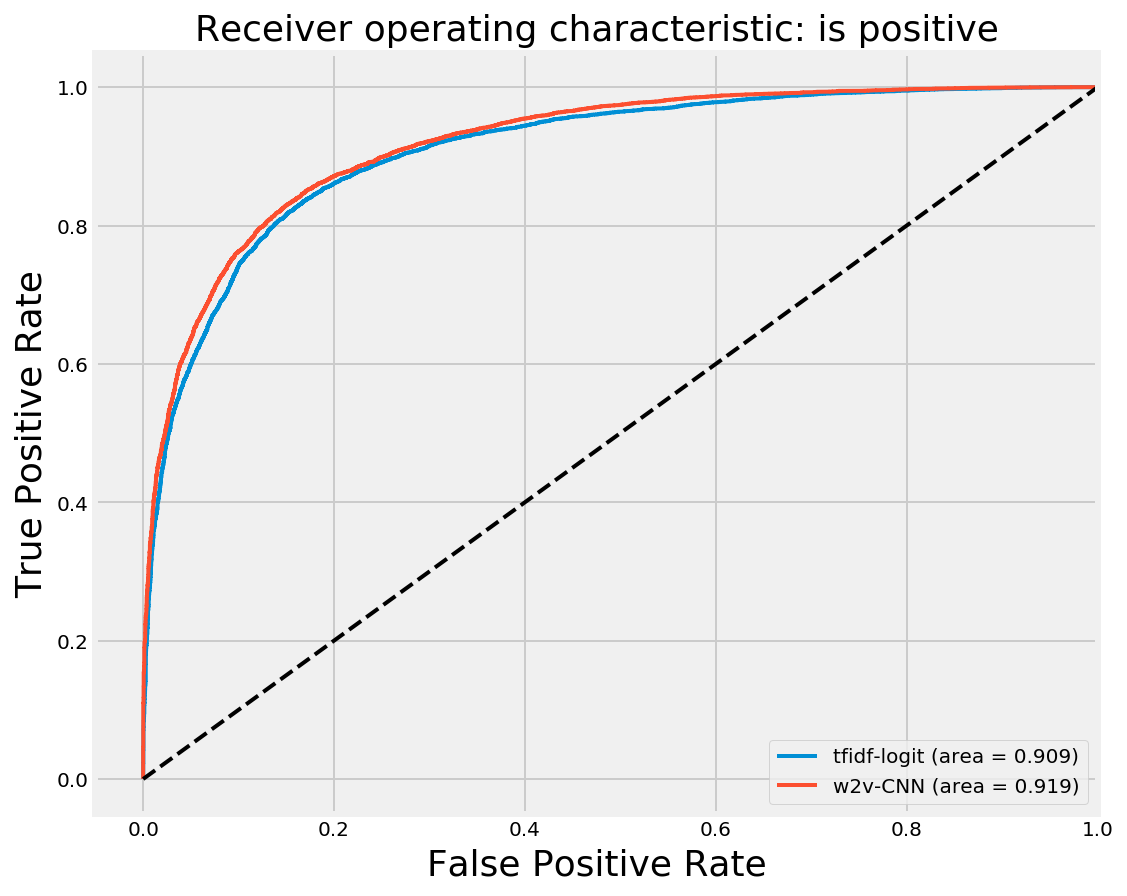

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

And the final result is as below.

| model | validation set accuracy | test set accuracy | ROC AUC |
|--|--|--|--|--|--|
|Tf-Idf + logistic regression | 82.91% | 83.30% | 0.91 |
|Word2Vec + CNN | 83.33% | 83.86% | 0.92 |